In [ ]:
#  region 컬럼에서
# 젠트리피케이션 지역  ['대학로', '북촌', '서촌', '홍대입구역', '합정', '연남', '해방촌', '경리단길',  '종로3가', '성수동', '신사동 가로수길', '송리단길', '명동', '신림', '문래', '이수역', '용리단길']
# 비젠트리피케이션 지역 ['강남역', '압구정로데오', '건대입구역', '여의도역', '동대문', '잠실역', '회기역', '영등포', '청담', '사당']
# 기본상권지로 설정한 지역 [성내동, 시흥동, 삼양동, 중화동,  월계동, 응암동, 신도림동, 신정동, 도봉동, 방화동]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
!pip uninstall -y pyLDAvis
!pip install pyLDAvis

Found existing installation: pyLDAvis 3.4.1
Uninstalling pyLDAvis-3.4.1:
  Successfully uninstalled pyLDAvis-3.4.1
  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)


In [ ]:
# !pip uninstall -y numpy
# !pip install numpy==1.23.5

In [ ]:
!pip install konlpy

In [ ]:
import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 데이터 로드
file_path = "/content/kakao_map_place_comment_final.csv"  # 업로드한 파일 경로
df = pd.read_csv(file_path)

In [ ]:
# 지역별 분류
gentrified_regions = ['대학로', '북촌', '서촌', '홍대입구역', '합정', '연남', '해방촌', '경리단길',
                       '종로3가', '성수동', '신사동 가로수길', '송리단길', '명동', '신림', '문래',
                       '이수역', '용리단길']
non_gentrified_regions = ['강남역', '압구정로데오', '건대입구역', '여의도역', '동대문', '잠실역',
                          '회기역', '영등포', '청담', '사당']
baseline_regions = ['성내동', '시흥동', '삼양동', '중화동', '월계동', '응암동', '신도림동',
                    '신정동', '도봉동', '방화동']

In [ ]:
# 지역별 카테고리 추가
def categorize_region(region):
    if region in gentrified_regions:
        return '젠트리피케이션'
    elif region in non_gentrified_regions:
        return '비젠트리피케이션'
    elif region in baseline_regions:
        return '기본상권지'
    else:
        return '기타'

df['category'] = df['region'].apply(categorize_region)

# '기타' 지역 제외
df = df[df['category'] != '기타']

In [ ]:
# 텍스트 전처리 함수
okt = Okt()
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)  # 한글만 남기기
    tokens = okt.nouns(text)  # 명사 추출
    return " ".join(tokens)

# 리뷰 데이터 전처리
df['cleaned_comment'] = df['contents'].astype(str).apply(preprocess_text)

In [ ]:
# CountVectorizer 적용
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words=None
)
dtm = vectorizer.fit_transform(df['cleaned_comment'])

In [ ]:
# LDA 모델 적용 (토픽 개수 3개)
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

In [ ]:
lda.components_

array([[7.07831876e+01, 2.76574639e+02, 8.96257193e+00, ...,
        3.52456697e+01, 3.43890342e-01, 3.47320150e-01],
       [9.20648974e+02, 3.69876902e+03, 5.11843571e+00, ...,
        8.93156196e+01, 7.17453981e-01, 1.90453796e+01],
       [5.41567839e+02, 2.10656339e+02, 2.66918992e+02, ...,
        2.44387108e+01, 7.89386557e+01, 7.66073002e+01]])

In [ ]:
# 각 토픽별 주요 단어 출력
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Topic 1:
맛집 진짜 최고 김치 가성 칼국수 고기 만두 정말 여기

Topic 2:
가격 방문 정도 고기 웨이 생각 국물 사람 시간 포장

Topic 3:
직원 커피 분위기 사람 카페 손님 사장 음식 주문 자리



In [ ]:
# 문서별 토픽 분포
doc_topic_dist = lda.transform(dtm)
df['topic'] = doc_topic_dist.argmax(axis=1)

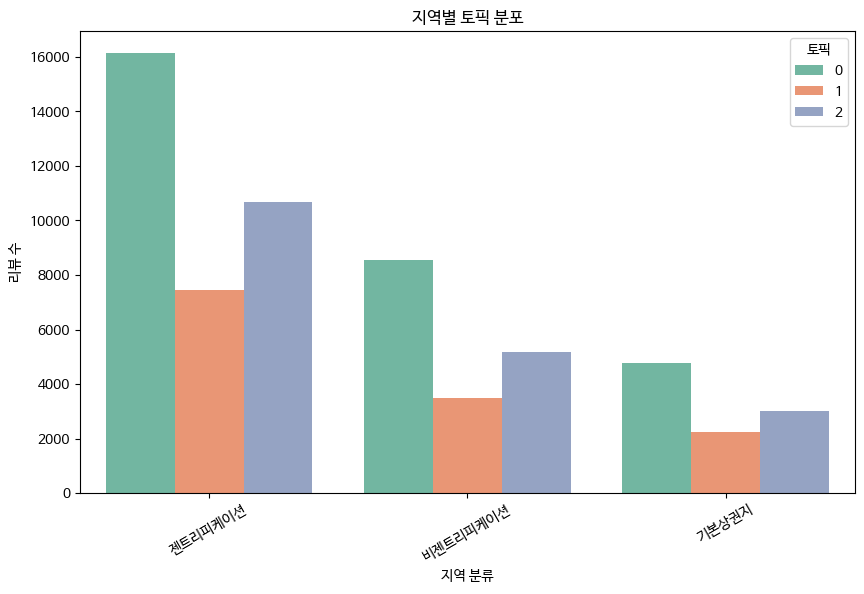

In [ ]:
# 지역별 토픽 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category', hue='topic', palette='Set2')
plt.title("지역별 토픽 분포")
plt.xlabel("지역 분류")
plt.ylabel("리뷰 수")
plt.legend(title="토픽")
plt.xticks(rotation=30)
plt.show()

In [ ]:
# !pip uninstall -y pyLDAvis scikit-learn sklearn

# !pip install -U pyLDAvis scikit-learn

In [ ]:
import pyLDAvis
import numpy as np

# pyLDAvis 활성화
pyLDAvis.enable_notebook()

# 단어 목록 및 빈도 계산
vocab = vectorizer.get_feature_names_out()
term_frequency = np.asarray(dtm.sum(axis=0)).flatten()

# BrokenProcessPool 오류 방지를 위해 `joblib` 사용 안 함
import joblib
joblib.parallel_backend('threading')

# LDA 시각화 실행
lda_visualization = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda.transform(dtm),
    doc_lengths=[len(doc.split()) for doc in df['cleaned_comment']],
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis.display(lda_visualization)

Topic 1 카페 및 분위기
Topic 2 서비스 및 방문 경험
Topic 3 음식 및 맛집
 로 추정..?

In [ ]:
print(df['category'].value_counts())

category
젠트리피케이션     34269
비젠트리피케이션    17229
기본상권지       10040
Name: count, dtype: int64


In [ ]:
df['category'] = df['category'].str.strip()

In [ ]:
print(df['region'].unique())

['대학로' '북촌' '서촌' '홍대입구역' '합정' '연남' '해방촌' '경리단길' '종로3가' '성수동' '송리단길' '명동'
 '신림' '문래' '이수역' '용리단길' '강남역' '압구정로데오' '건대입구역' '여의도역' '동대문' '잠실역' '회기역'
 '영등포' '청담' '사당' '성내동' '시흥동' '삼양동' '중화동' '월계동' '응암동' '신도림동' '신정동' '도봉동'
 '방화동']


# 지역별 토픽 비율
- Topic 1 (가장 큰 비중)
모든 지역에서 40~50%로 가장 높은 비중을 차지
비젠트리피케이션 지역(49.3%)이 가장 높고, 일반상권지(46.3%)가 가장 낮음
비젠트리피케이션 지역에서 특정 주제가 더 강하게 나타날 가능성 있음

- Topic 2 (가장 낮은 비중)
젠트리피케이션(20.9%)에서 가장 낮고, 일반상권지(23.5%)에서 가장 높음
일반상권지가 상대적으로 더 다양한 토픽을 포함하고 있을 가능성 있음

- Topic 3 (거의 비슷함)
젠트리피케이션(30.5%)과 일반상권지(30.2%)가 거의 비슷하고, 비젠트리피케이션(29.3%)이 가장 낮음

세 지역 모두 큰 차이는 없음

<Figure size 1000x600 with 0 Axes>

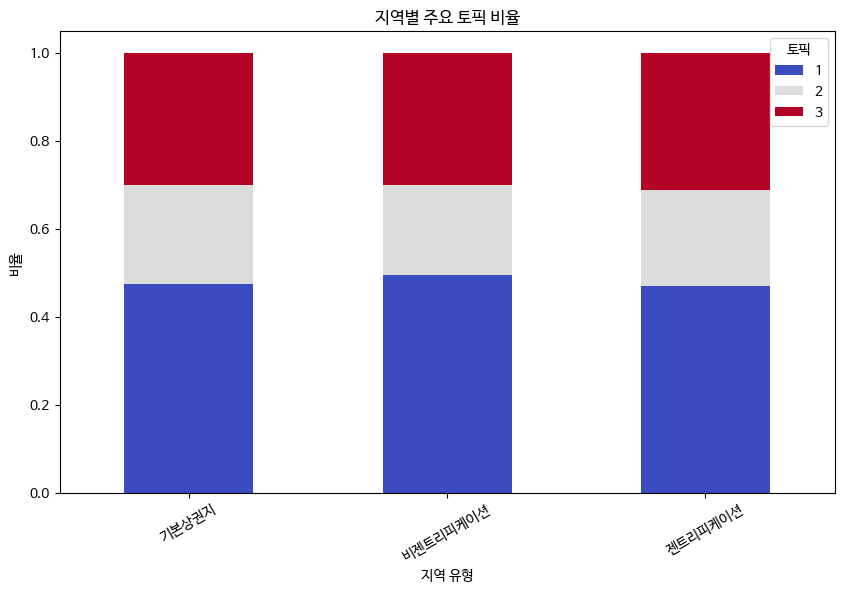

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LDA 모델로 각 리뷰가 어느 토픽에 속하는지 확률 계산
doc_topic_dist = lda.transform(dtm)

# 각 리뷰에 가장 높은 확률을 가진 토픽 할당
df['topic'] = doc_topic_dist.argmax(axis=1)

df['topic'] = df['topic'] + 1

# 지역별 토픽 분포 분석
topic_distribution = df.groupby('category')['topic'].value_counts(normalize=True).unstack()

plt.figure(figsize=(10, 6))
topic_distribution.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))
plt.title("지역별 주요 토픽 비율")
plt.xlabel("지역 유형")
plt.ylabel("비율")
plt.legend(title="토픽")
plt.xticks(rotation=30)
plt.show()

In [ ]:
topic_distribution

topic,1,2,3
category,,,
기본상권지,0.476295,0.223008,0.300697
비젠트리피케이션,0.496663,0.203204,0.300133
젠트리피케이션,0.470921,0.217456,0.311623
